In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [32]:
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color =  '#A6F0C6'

In [6]:
data = pd.read_csv('fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [ ]:

nlp = spacy.load('en_core_web_sm')

# split data by fake and factual news
fake_news = data[data['fake_or_factual'] == "Fake News"]
fact_news = data[data['fake_or_factual'] == "Factual News"]

# create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fact_spaceydocs = list(nlp.pipe(fact_news['text'])) 

In [8]:
# creating function to extract tags 
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [9]:
# tag fake dataset 
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)
        
fake_tagsdf = pd.concat(fake_tagsdf)   

# tag factual dataset 
fact_tagsdf = []

for ix, doc in enumerate(fact_spaceydocs):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)
        
fact_tagsdf = pd.concat(fact_tagsdf)   

In [10]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [11]:
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [13]:
# frequencies of pos tags
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [12]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [14]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [ ]:
# Select top 15 NOUNs
real_nouns = pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:15].reset_index(drop=True)
fake_nouns = pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:15].reset_index(drop=True)

# Rename token column 
real_nouns = real_nouns.rename(columns={'token': 'real_token'})
fake_nouns = fake_nouns.rename(columns={'token': 'fake_token'})

# Concatenate horizontally
combined = pd.concat([real_nouns, fake_nouns], axis=1)
print(combined)

        real_token pos_tag  counts  fake_token pos_tag  counts
0       government    NOUN      71      people    NOUN      77
1             year    NOUN      64           t    NOUN      65
2            state    NOUN      57   president    NOUN      58
3             bill    NOUN      55       women    NOUN      55
4   administration    NOUN      51        time    NOUN      52
5        president    NOUN      49    campaign    NOUN      44
6         election    NOUN      48        year    NOUN      44
7           people    NOUN      45  government    NOUN      41
8            order    NOUN      45         law    NOUN      40
9              law    NOUN      42       years    NOUN      40
10        campaign    NOUN      42       state    NOUN      38
11             tax    NOUN      39    election    NOUN      37
12       reporters    NOUN      38         day    NOUN      35
13       statement    NOUN      37       media    NOUN      35
14           court    NOUN      37     country    NOUN 

# Names Entities

In [17]:
# top entities in fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

In [18]:

# top entities in fact news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)

In [19]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

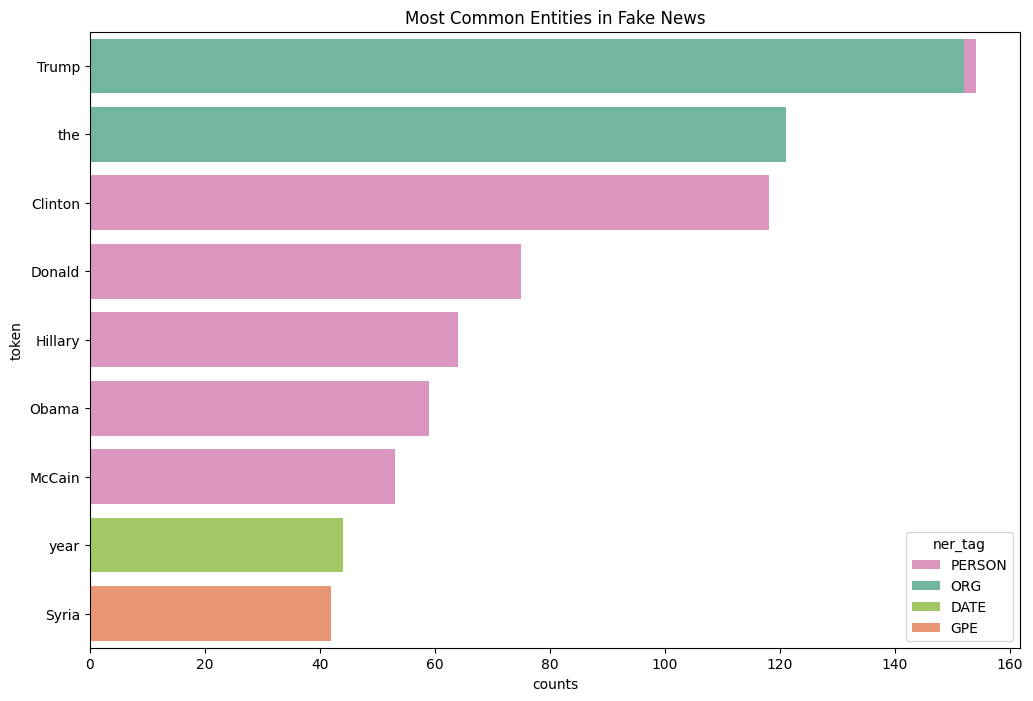

In [20]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

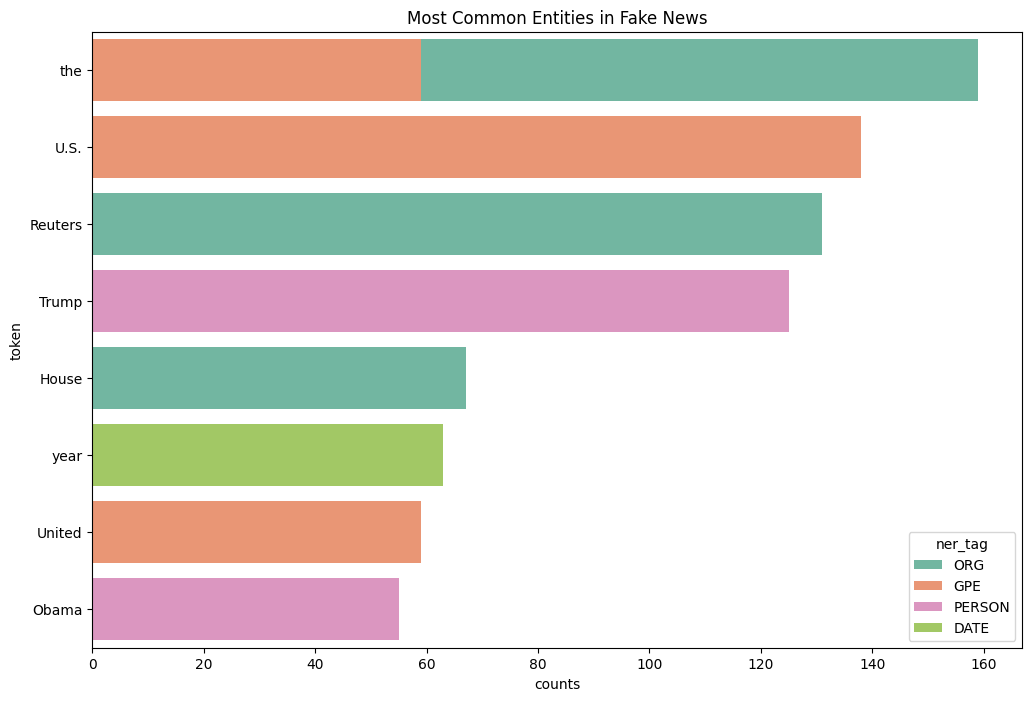

In [21]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

# Processing text

In [ ]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1) # Match from the start up to the first dash and following whitespace

In [23]:
data['text_clean'] = data['text_clean'].str.lower()

In [24]:
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [25]:
en_stopwords = stopwords.words('english')
print(en_stopwords) #most frequent n-grams

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [26]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))


In [27]:
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)


In [28]:
# lemmatize
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [29]:
# unigrams
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


/var/folders/kn/jqlfdf8s3ms9j967wwzclt4h0000gn/T/ipykernel_40369/673530707.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

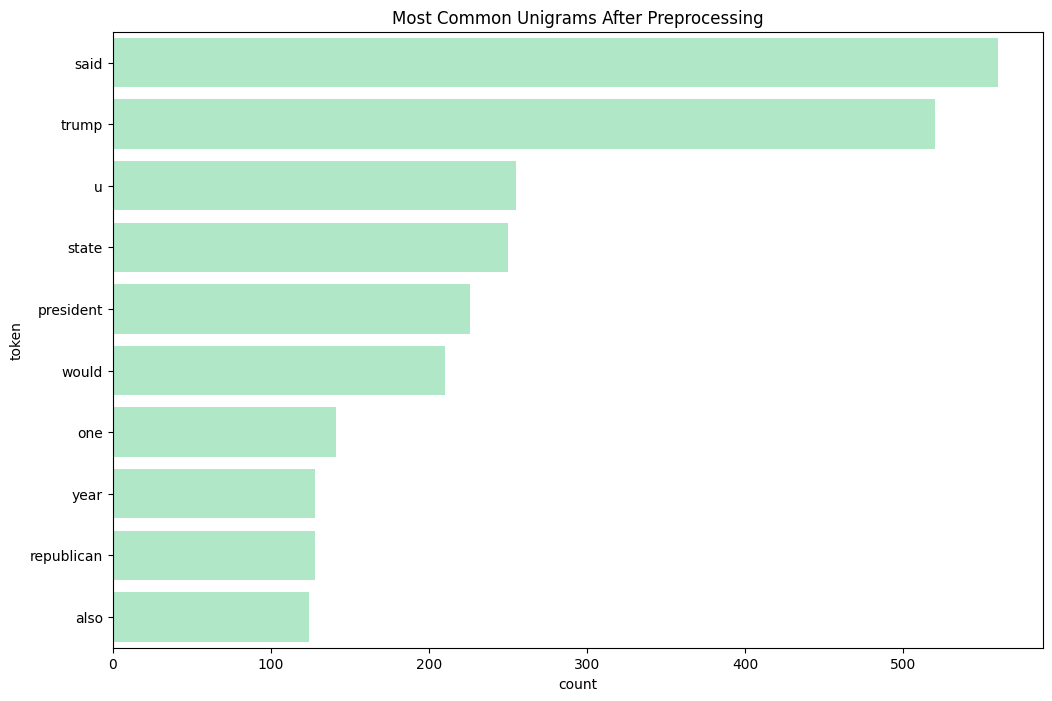

In [33]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',
            palette=[default_plot_color],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [34]:
#Bigram
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()) 
print(bigrams[:10])

(donald, trump)        92
(united, state)        80
(white, house)         72
(president, donald)    42
(hillary, clinton)     31
(new, york)            31
(image, via)           29
(supreme, court)       29
(official, said)       26
(food, stamp)          24
Name: count, dtype: int64


# Sentiment Analysis

In [35]:
vader_sentiment = SentimentIntensityAnalyzer()


In [36]:
data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])


In [37]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

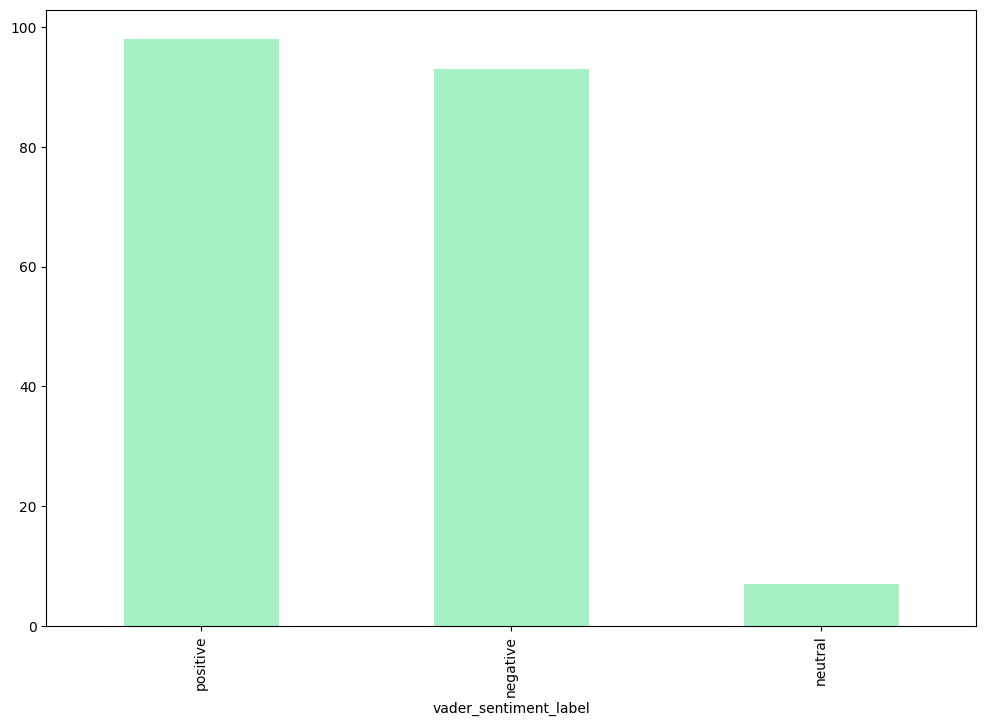

In [38]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_color)


/var/folders/kn/jqlfdf8s3ms9j967wwzclt4h0000gn/T/ipykernel_40369/1282747491.py:1: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

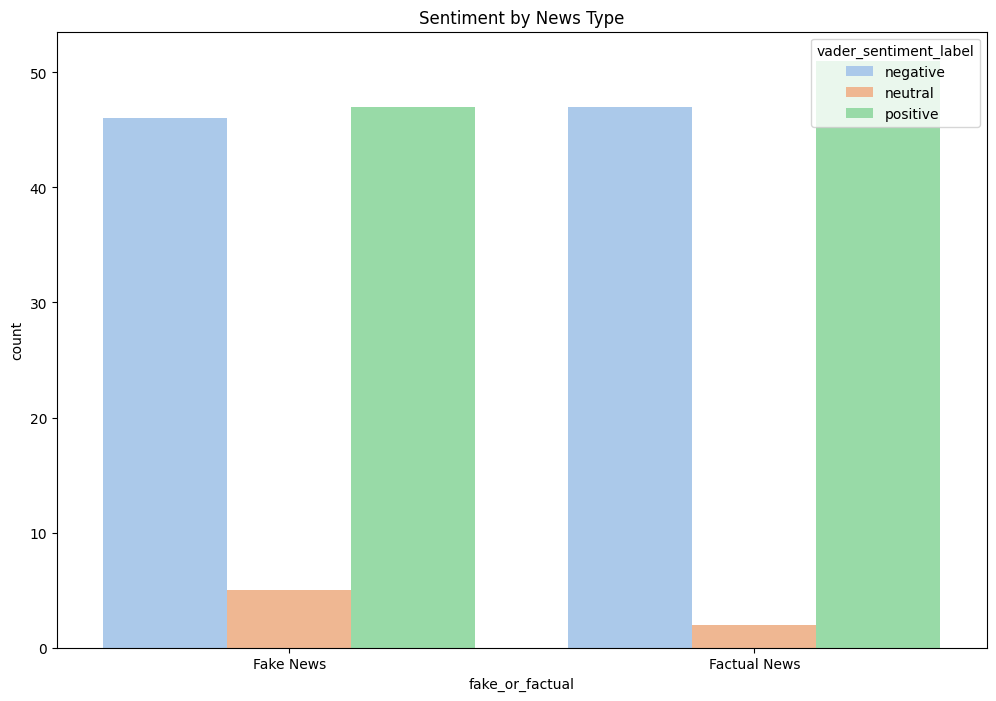

In [40]:

sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("pastel"),
    data = data
) \
.set(title='Sentiment by News Type')

## LDA

In [41]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text)
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

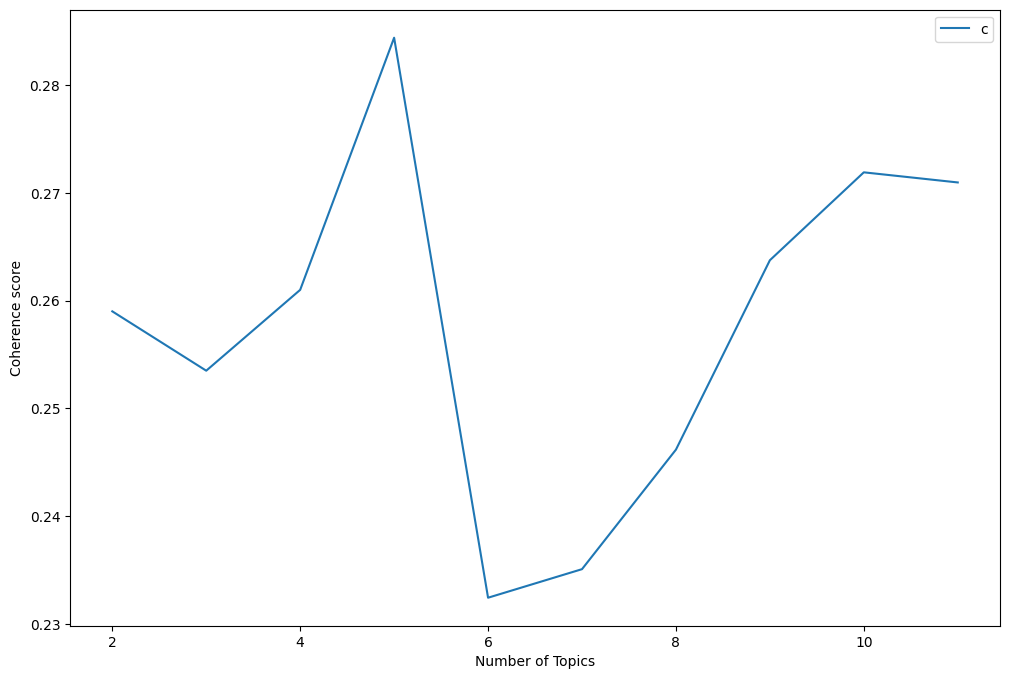

In [42]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [68]:
num_topics_fake = 5

lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake,
                                       id2word=dictionary_fake,
                                       num_topics=num_topics_fake)

lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.007*"trump" + 0.004*"u" + 0.004*"one" + 0.003*"said" + 0.003*"would" + 0.003*"state" + 0.003*"president" + 0.003*"woman" + 0.003*"like" + 0.003*"year"'),
 (1,
  '0.011*"trump" + 0.005*"clinton" + 0.005*"republican" + 0.004*"would" + 0.004*"said" + 0.003*"time" + 0.003*"president" + 0.003*"go" + 0.003*"also" + 0.003*"donald"'),
 (2,
  '0.012*"trump" + 0.005*"president" + 0.005*"said" + 0.004*"time" + 0.004*"state" + 0.004*"u" + 0.003*"clinton" + 0.003*"would" + 0.003*"republican" + 0.003*"woman"'),
 (3,
  '0.017*"trump" + 0.005*"said" + 0.005*"clinton" + 0.004*"president" + 0.004*"state" + 0.003*"donald" + 0.003*"one" + 0.003*"woman" + 0.003*"time" + 0.002*"people"'),
 (4,
  '0.007*"trump" + 0.006*"said" + 0.006*"state" + 0.005*"clinton" + 0.005*"would" + 0.004*"million" + 0.004*"one" + 0.004*"food" + 0.004*"stamp" + 0.003*"u"')]

## TF-IDF & LSA

In [45]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [46]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

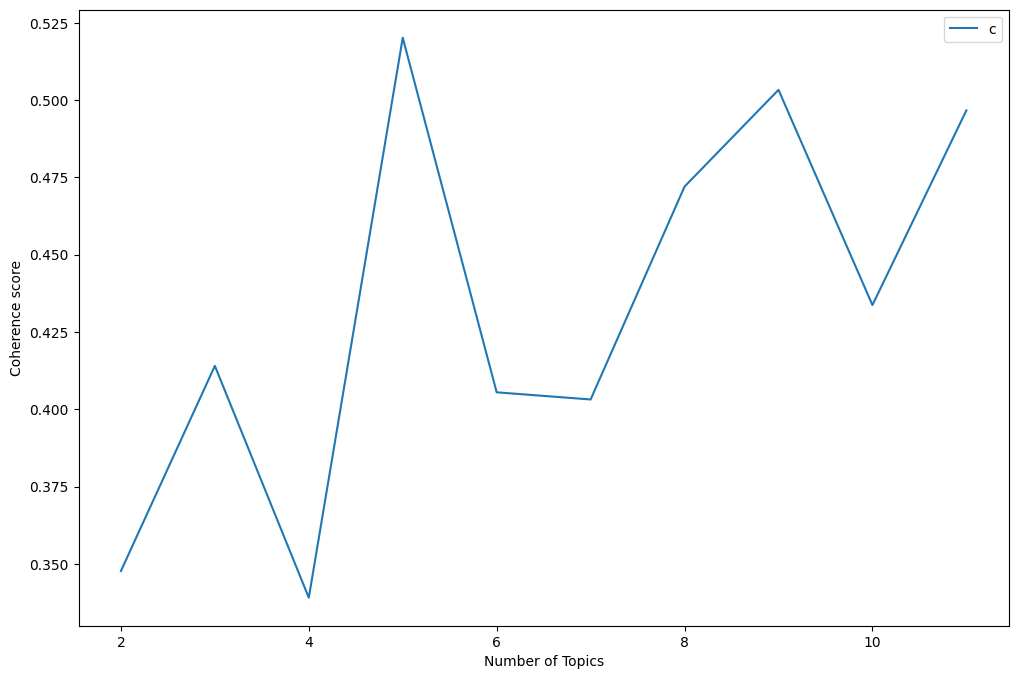

In [47]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [55]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '-0.218*"trump" + -0.135*"clinton" + -0.094*"woman" + -0.087*"president" + -0.086*"republican" + -0.085*"obama" + -0.084*"party" + -0.083*"school" + -0.081*"said" + -0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"savant" + -0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '-0.235*"trump" + -0.223*"flynn" + -0.166*"conference" + 0.165*"clinton" + 0.153*"dnc" + 0.151*"sander" + 0.127*"email" + -0.111*"press" + 0.109*"rich" + -0.084*"tax"')]

# Predictions

In [56]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [57]:
x = [','.join(map(str, l)) for l in data['text_clean']]
y = data['fake_or_factual']

In [58]:
# CountVectorizer
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())

In [59]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

## Logit

In [60]:
lr = LogisticRegression(random_state=0).fit(x_train, y_train)

In [61]:
y_pred_lr = lr.predict(x_test)

In [62]:
accuracy_score(y_pred_lr, y_test)

0.85

In [63]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.79      0.88      0.83        25
   Fake News       0.91      0.83      0.87        35

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.86      0.85      0.85        60



## SVM

In [64]:
svm = SGDClassifier().fit(x_train, y_train)

In [65]:
y_pred_svm = svm.predict(x_test)

In [66]:
accuracy_score(y_pred_svm, y_test)

0.9

In [67]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.83      0.96      0.89        25
   Fake News       0.97      0.86      0.91        35

    accuracy                           0.90        60
   macro avg       0.90      0.91      0.90        60
weighted avg       0.91      0.90      0.90        60



### CHAMPION MODEL: SVM (SGDClassifier)
After comparing Logistic Regression and SVM on fake news classification, SVM consistently outperformed Logistic Regression across all key metrics, including accuracy, precision, recall, and F1-score

SVM was especially effective at predicting Fake News, likely due to its strength in handling sparse data. Fake news often contains noisier and less structured language, which SVM appears to manage more effectively than Logistic Regression.